# Neural Style Transfer
**Problem Statement:--**  
Given an Input image and a style produce an image that is combination of two.  
****
Neural Style Transfer is process of using CNN to render a content image in different styles.  
****
There are bascially two images   
1) Content Image also called as input image to which style is to be applied.  
2) Style Image whose style is used in content image.  

Result of the content and style image is called as Generated image,which has the properties from both of the images.



In [0]:
##uploading 1st style
from google.colab import files
files.upload()

In [0]:
##Uploading content
files.upload()

# Why Pretrained Model??
we would have used our own custom made CNN to address the style transfer problem but the problem is the amont of training required to make it perfect is difficult as we need to feed it huge amount of data.  
Also we are not building any classification model so we can use pretrained model.  
**CNN are pretrained for images and already know how to encode perceptual and semantic information about the images.  
In case of style transfer tasks we need only the hidden layers as the learning of deep layers will be helping to make the effect.**  


VGG16 is the classic CNN trained on IamgeNet data so we can happily use it to perform our task.

In [3]:
##Necessary imports

from keras.applications.vgg16 import VGG16,preprocess_input,decode_predictions
from keras import backend as k
from keras.models import Model

'''
lbfgs has outformed all other optimizers so it is used(acc to research)
even it converges faster then gradient descent.
'''

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
from PIL import Image
import numpy as np

Using TensorFlow backend.


<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=990x663 at 0x7F9298F05780>


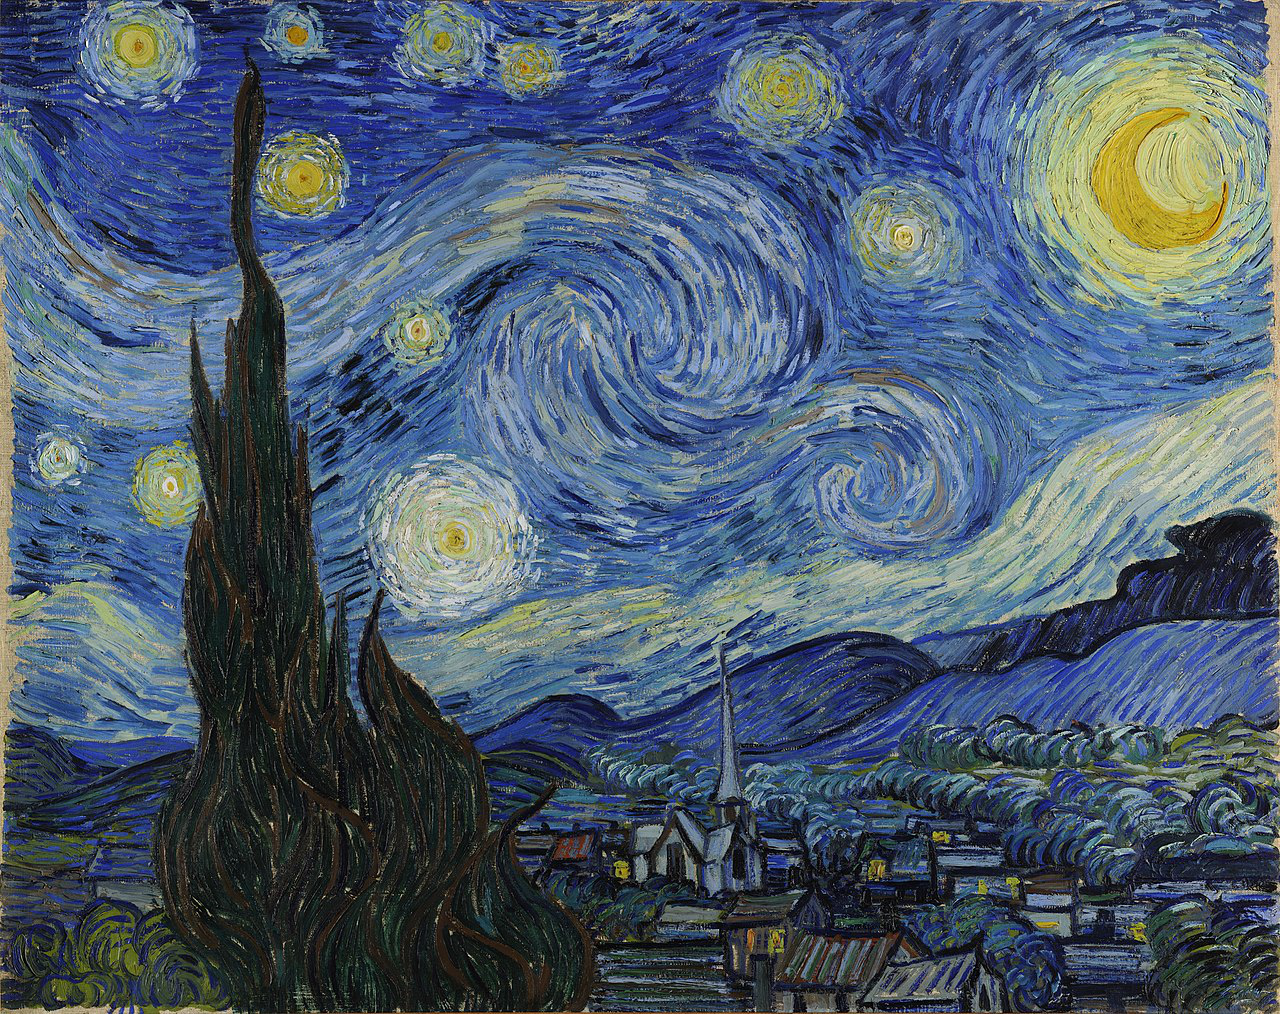

In [29]:
##getting the styles
style_image = Image.open('starry_night.jpg')
style_image

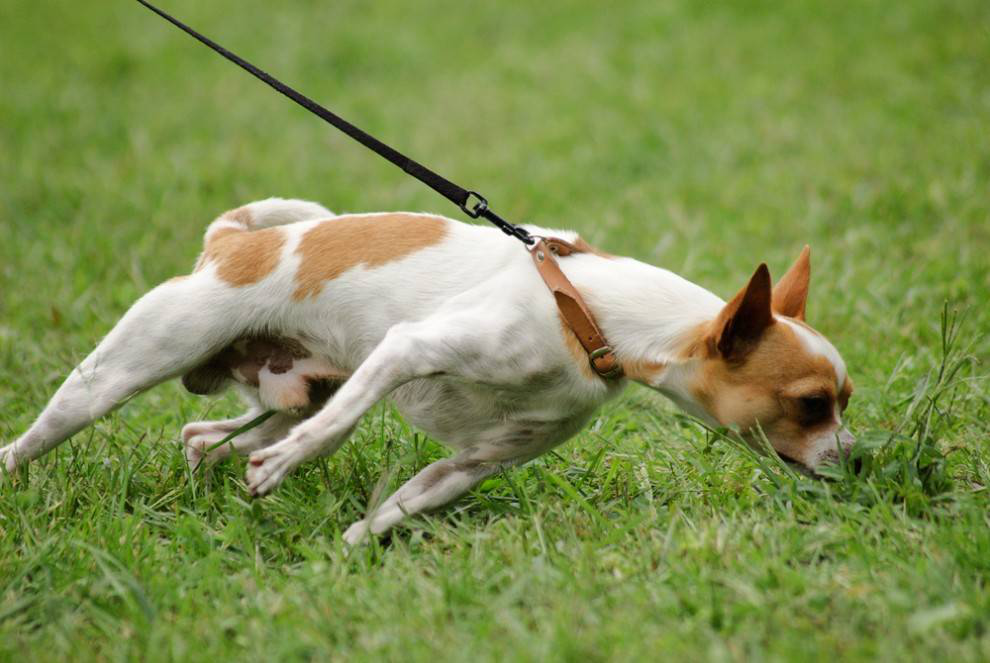

In [30]:
##getting the content image
content_image = Image.open('dog.jpg')
content_image

In [0]:
##Resize the images

##Because we have 512 units in VGGnet
content_image = content_image.resize((512,512))
style_image = style_image.resize((512,512))

##conveting in to array
content_array = np.asarray(content_image,dtype = 'float32')
##Expanding the dimension because we'll concatenate with  the style_image on this new axis.
content_array = np.expand_dims(content_array,axis = 0)

style_array = np.asarray(style_image,dtype = 'float32')
style_array = np.expand_dims(style_array,axis = 0)

# Why??
**Before we preceed some important points**  
*1) Subtract the mean of RGB value from each pixel.*  
the means are precaluculated and can be eaisly found on Internet.  
*2)Flip the ordering of the multidimesional array from RGB to BGR*  
suggested in the paper of Style transfer.

In [0]:
##Modification

#mean substraction
#R
content_array[:,:,:,0] -= 103.939
#G
content_array[:,:,:,1] -= 116.779
#B
content_array[:,:,:,2] -= 123.68


##Flipping
content_array = content_array[:,:,:,::-1]

style_array[:,:,:,0] -= 103.939
style_array[:,:,:,1] -= 116.779
style_array[:,:,:,2] -= 123.68

style_array = style_array[:,:,:,::-1]

In [0]:
##Height and width are selected as 512 X 512 because our VGG 16 has this shape

height = 512
width = 512


content_image = k.variable(content_array)
style_image = k.variable(style_array)
##defining a placeholder for our generated image
generated_image = k.placeholder((1,height,width,3))


##Concatenating the images in one tensor
imput_tensor = k.concatenate([content_image,style_image,generated_image],axis = 0)

In [14]:
#Calling VGG 16 with weights specified to ImageNet

## we are excluding the fully connected layers as we dont need them

model = VGG16(input_tensor = imput_tensor,
             weights = 'imagenet',
             include_top = False)


##Hyperparameters
#alpha
content_weight = 0.05
#Beta
style_weight = 5.0
#used to reduce the noise as Regularizer
total_variation_weight = 1.0


## getting the layers of the VGG16
layers = dict([(layer.name,layer.output) for layer in model.layers])
layers

{'block1_conv1': <tf.Tensor 'block1_conv1/Relu:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2/Relu:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool/MaxPool:0' shape=(3, 256, 256, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1/Relu:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2/Relu:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool/MaxPool:0' shape=(3, 128, 128, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool/MaxPool:0' shape=(3, 64, 64, 256) dtype=float32>,
 'block4_conv1': <tf.Tensor 'block4_conv1/Relu:0' shape=(3, 64, 64, 512) dtype=float32>,
 'b

In [15]:
## defining the loss to 0

loss = k.variable(0.)


##Defining the content loss
def content_loss(content,generated):
  return k.sum(k.square(content-generated))

##getting any mid layer of the VGG16
layer_features = layers['block2_conv2']
content_image_features = layer_features[0,:,:,:]
generated_features = layer_features[2,:,:,:]

##Updating the loss
loss += content_weight*content_loss(content_image_features,generated_features)

# Details 


**For the style loss, we first define something called a Gram matrix. The terms of this matrix are proportional to the covariances of corresponding sets of features, and thus captures information about which features tend to activate together. By only capturing these aggregate statistics across the image, they are blind to the specific arrangement of objects inside the image. This is what allows them to capture information about style independent of content.**  

****


In [0]:
def gram_matrix(x):
    features = k.batch_flatten(k.permute_dimensions(x, (2, 0, 1)))
    gram = k.dot(features, k.transpose(features))
    return gram
  
def style_loss(style, generated):
    S = gram_matrix(style)
    C = gram_matrix(generated)
    channels = 3
    size = height * width
    return k.sum(k.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

feature_layers = ['block1_conv2', 'block2_conv2',
                  'block3_conv3', 'block4_conv3',
                  'block5_conv3']
for layer_name in feature_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, :, :, :]
    generated_features = layer_features[2, :, :, :]
    sl = style_loss(style_features, generated_features)
    loss += (style_weight / len(feature_layers)) * sl

# Why 3rd loss??
If you were to solve the optimisation problem with only the two loss terms we’ve introduced so far (style and content), you’ll find that the output is quite noisy. We thus add another term, called the total variation loss (a regularisation term) that encourages spatial smoothness.

In [0]:
def total_variation_loss(x):
    a = k.square(x[:, :height-1, :width-1, :] - x[:, 1:, :width-1, :])
    b = k.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return k.sum(k.pow(a + b, 1.25))

  
##Updating the weight
loss += total_variation_weight * total_variation_loss(generated_image)


In [0]:
##Defining the gradient used for minimizing

grads = k.gradients(loss, generated_image)


outputs = [loss]
outputs += grads
f_outputs = k.function([generated_image], outputs)

def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values
  
##use of Evaluator class as scipy needs loss and grads to be calculated saperately

class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

In [23]:
##Running on GPU(Google COLAB)


import time

##using random image which will act as generated image when the iteration completes.

x = np.random.uniform(0, 255, (1, height, width, 3)) - 128.

iterations = 15


for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    ##Using lbfhs algo for minimizing the style and content loss
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20) 
    print('Current loss value:', min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))
##

Start of iteration 0
Current loss value: 82465430000.0
Iteration 0 completed in 18s
Start of iteration 1
Current loss value: 53275554000.0
Iteration 1 completed in 18s
Start of iteration 2
Current loss value: 47658693000.0
Iteration 2 completed in 18s
Start of iteration 3
Current loss value: 45531865000.0
Iteration 3 completed in 18s
Start of iteration 4
Current loss value: 44713390000.0
Iteration 4 completed in 18s
Start of iteration 5
Current loss value: 44207890000.0
Iteration 5 completed in 18s
Start of iteration 6
Current loss value: 43909743000.0
Iteration 6 completed in 18s
Start of iteration 7
Current loss value: 43717992000.0
Iteration 7 completed in 18s
Start of iteration 8
Current loss value: 43574390000.0
Iteration 8 completed in 18s
Start of iteration 9
Current loss value: 43463455000.0
Iteration 9 completed in 18s
Start of iteration 10
Current loss value: 43383755000.0
Iteration 10 completed in 18s
Start of iteration 11
Current loss value: 43320390000.0
Iteration 11 compl

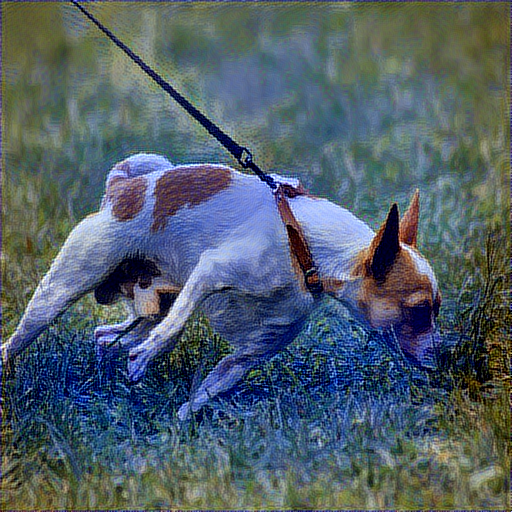

In [24]:
##getting our image to original shape
x = x.reshape((height, width, 3))
##flipping 
x = x[:, :, ::-1]

##adding the means of R G B channels
x[:, :, 0] += 103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68
x = np.clip(x, 0, 255).astype('uint8')

##Showing the image
Image.fromarray(x)



In [25]:
##Saving the image

import matplotlib.pyplot as plt
plt.savefig('x.png')

In [0]:
files.download('x.png')